In [2]:
# Installing required libraries
!pip install geopandas
!pip install rasterio
!pip install shapely
!pip install pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.5 MB/s eta 0:00:00


We have syangja district as area of interest and 4 SRTM DEM tiff files which combinely cover the syangja district  so first we will merge these four tiff files and then clip precisely using the district boundary.

In [3]:
# importing required libraries
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt

In [8]:
import os

os.environ['SHAPE_RESTORE_SHX'] = 'YES'  # Set the environment variable

# Now try to read the file
aoi = gpd.read_file('/content/Syangja.shp')

<Axes: >

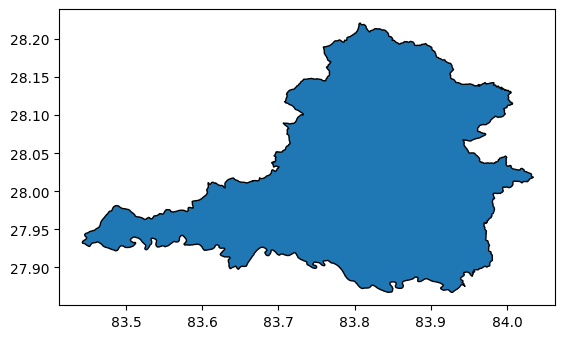

In [14]:
#Visualizing shapefile
aoi.plot(edgecolor = 'k')

In [18]:
import glob
# Directory of raster files(DEM) to merge
raster_dir = '/content/Raster'

raster_files = glob.glob(os.path.join(raster_dir, '*.tif'))

#creating list to hold all the raster files
files_to_mosaic = []

In [19]:
# Reading raster files and appending to the list
for file in raster_files:
    src = rasterio.open(file)
    files_to_mosaic.append(src)


In [21]:
from rasterio.merge import merge# Perform the merge
mosaic, out_trans = merge(files_to_mosaic)

# Copy the metadata
out_meta = files_to_mosaic[0].meta.copy()


In [22]:
# Update the metadata with new dimensions, transform, and crs
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,
    "crs": files_to_mosaic[0].crs
})


In [23]:
# Define output directory for merged raster
output_dir = '/content/output_rasters'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Save the merged raster
merged_raster_path = os.path.join(output_dir, 'merged.tif')
with rasterio.open(merged_raster_path, "w", **out_meta) as dest:
    dest.write(mosaic)

In [25]:
#Visualize individual raster with area of interest
# Function to plot individual rasters and the shapefile overlay
def plot_raster_shapefile(raster_path, shapefile, title):
    with rasterio.open(raster_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, cmap='terrain')
        shapefile.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)  # Overlay the shapefile
        ax.set_title(title)
        plt.show()


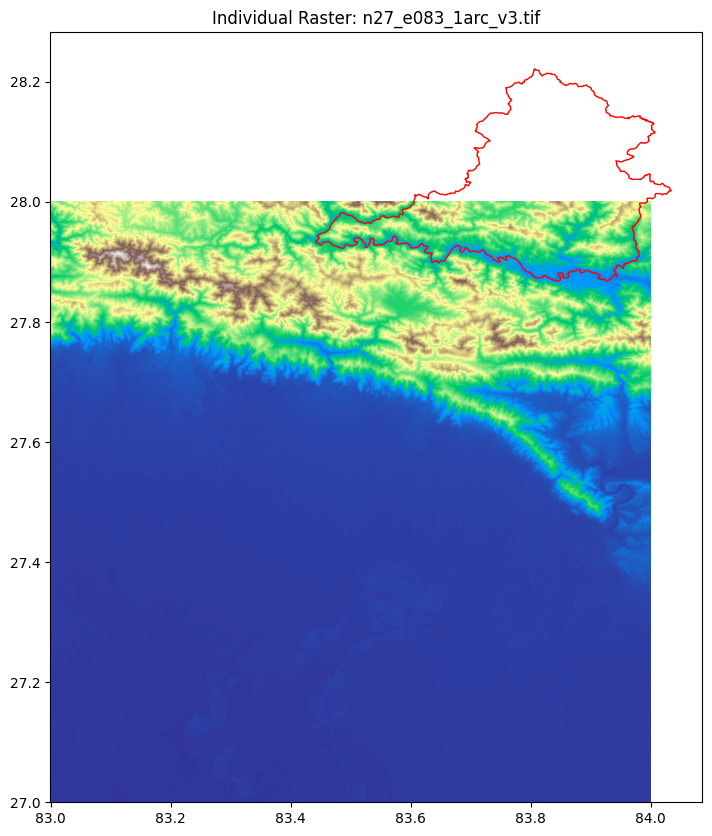

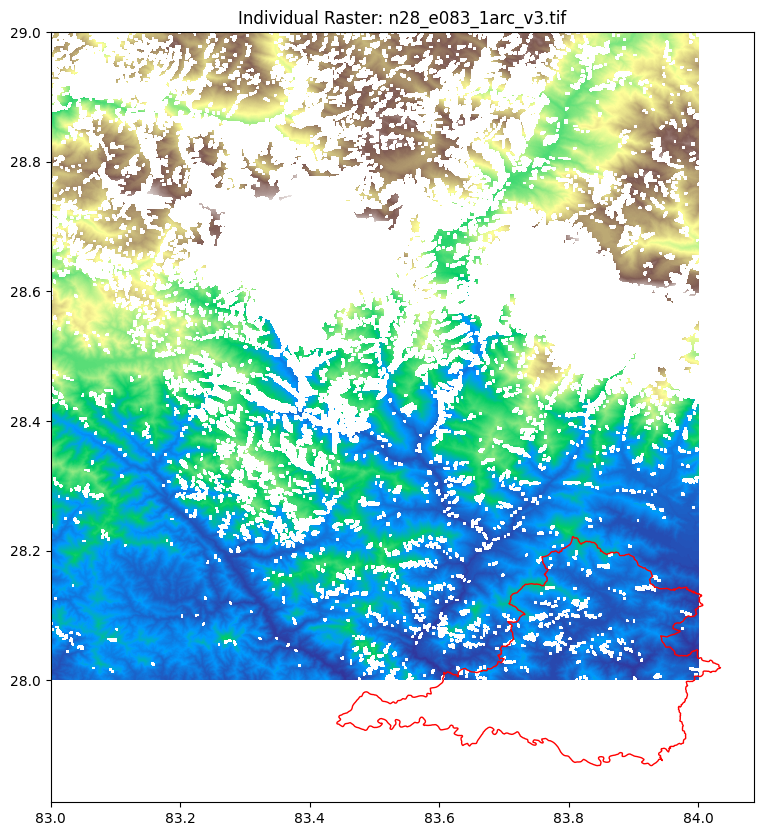

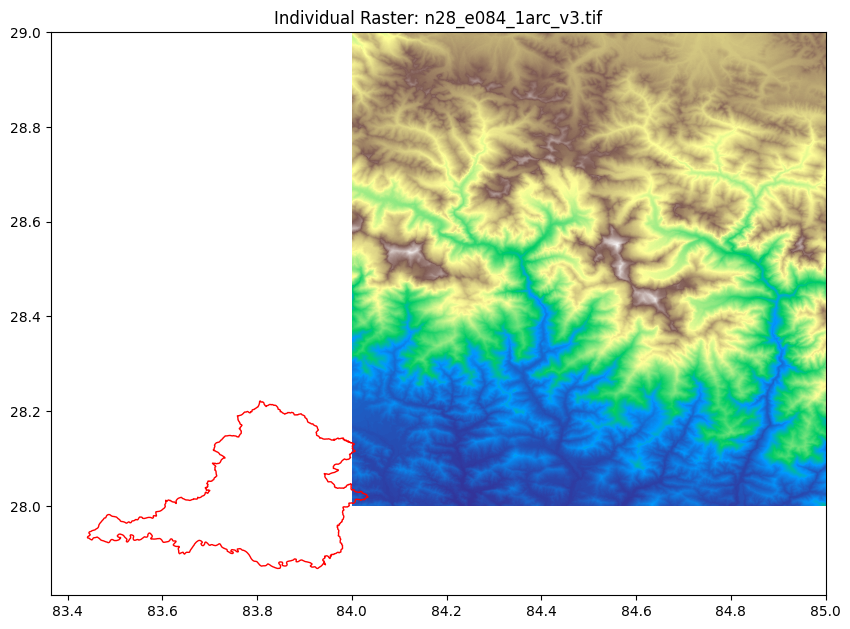

In [26]:
# Plot individual raster files with the shapefile overlay
for raster_file in raster_files:
    plot_raster_shapefile(raster_file, aoi, f"Individual Raster: {os.path.basename(raster_file)}")


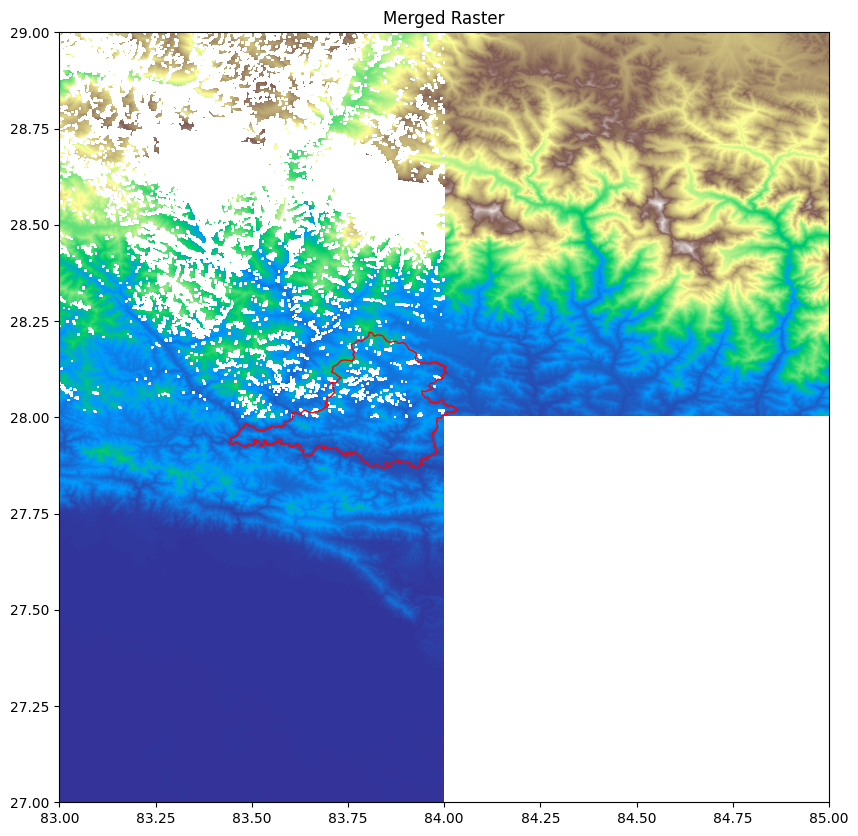

In [27]:
# Plot the merged raster file with the shapefile overlay
plot_raster_shapefile(merged_raster_path, aoi, "Merged Raster")

Now we will clip the merged raster file with aoi shapefile

In [31]:
from rasterio.mask import mask

# Load the merged raster
merged_raster_path = '/content/output_rasters/merged.tif'
with rasterio.open(merged_raster_path) as src:
    # Load the area of interest shapefile
    aoi = gpd.read_file('/content/Syangja.shp')


    # Check if the shapefile has a CRS
    if aoi.crs is None:
        aoi = aoi.set_crs(epsg=4326)  # Set wgs84 crs

    # Ensure the CRS of the shapefile matches the raster
    aoi = aoi.to_crs(src.crs)

    # Get the geometry from the shapefile
    geoms = aoi.geometry.values

    # Clip the raster using the shapefile geometry
    out_image, out_transform = mask(src, geoms, crop=True)

    # Copy the metadata from the original raster
    out_meta = src.meta.copy()

    # Update the metadata for the clipped raster
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "crs": src.crs
    })

    # Define the output path for the clipped raster
    clipped_raster_path = '/content/output_rasters/syangja_dem.tif'

    # Save the clipped raster
    with rasterio.open(clipped_raster_path, "w", **out_meta) as dest:
        dest.write(out_image)


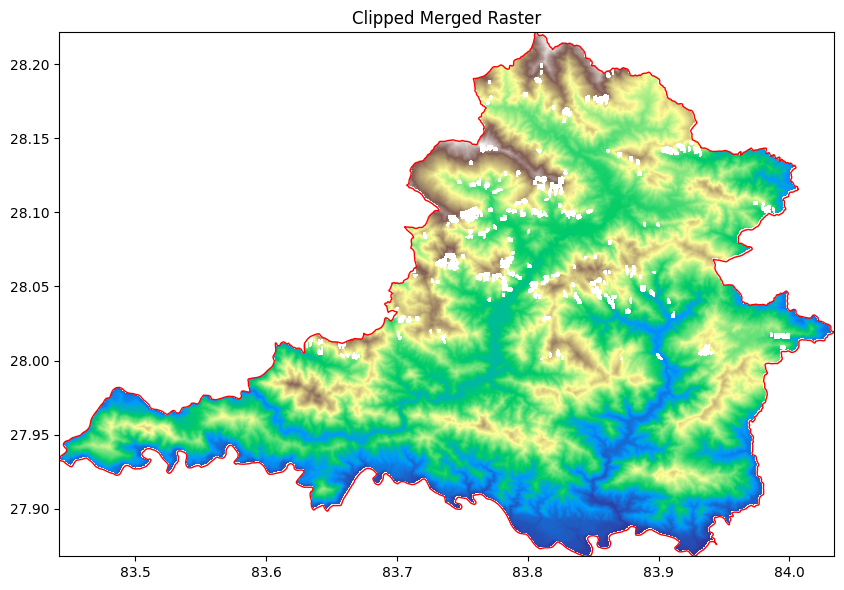

In [32]:
# Plot the clipped raster
from rasterio.plot import show
with rasterio.open('/content/output_rasters/syangja_dem.tif') as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, cmap='terrain')
    aoi.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)  # Overlay the shapefile
    ax.set_title("Clipped Merged Raster")
    plt.show()